In [1]:
import dataset
import utils
import reference_impl as ref
import predictors
import model

# Use this cfg variable whenever we need to access some constant
cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=32,
    num_subcarriers=80,
    train_test_split=0.8,
    data_root="../data/dataset1",
    reduce_pca_overhead=False
    # duplicate_data=1,
    # data_snr=-1
)

train_set = dataset.dataset_from_path("../data/dataset1/1Lane_2014U_1Rx_32Tx_1T_80K_2620000000.0fc.pickle", cfg)

In [2]:
## Offline Training
import matlab.engine

matlab = matlab.engine.start_matlab()
pca = ref.ReferencePCA(cfg, matlab)
model.train_or_load(pca, cfg.pca_path, cfg.retrain_all, train_set.csi_samples)  # pca.fit() includes reduce overhead
zdl_train = pca.process(train_set.csi_samples)  # N * zdl_len

In [3]:
## Train Predictor
predictor = predictors.VARPredictor(cfg)
model.train_or_load(predictor, cfg.predictor_path, cfg.retrain_all, zdl_train)

In [16]:
import numpy as np
max_lag = max(predictor.imag_lag_order, predictor.real_lag_order)
predicted_shape = (zdl_train.shape[0] - max_lag, *zdl_train.shape[1:])
predicted_zdl = np.zeros_like(zdl_train)
for i in range(max_lag, len(zdl_train)):
    window = zdl_train[i-max_lag : i]
    predicted_zdl[i] = predictor.process(window)

<Figure size 640x480 with 0 Axes>

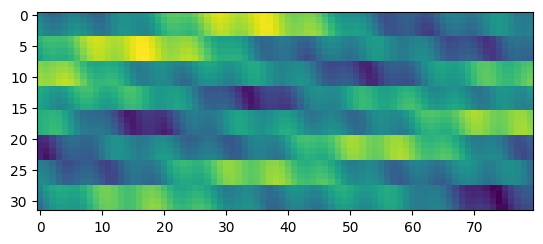

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
ori = np.expand_dims(train_set[10].csi, axis=0)
plt.imshow(np.squeeze(np.abs(ori)))
plt.figure()


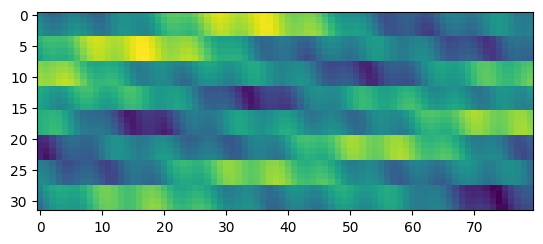

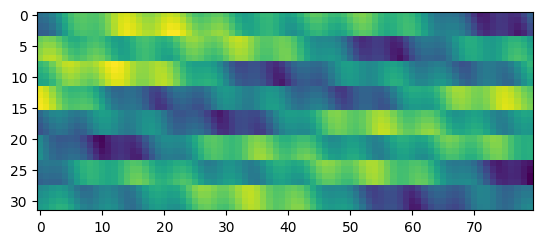

In [18]:
def plot(zdl):
    plt.figure()
    zdl = np.expand_dims(zdl, axis=0)
    recovered = pca.decode(zdl)
    plt.imshow(np.squeeze(np.abs(recovered)))

single_zdl = zdl_train[10]
single_pred = predicted_zdl[10]

plot(single_zdl)
plot(single_pred)

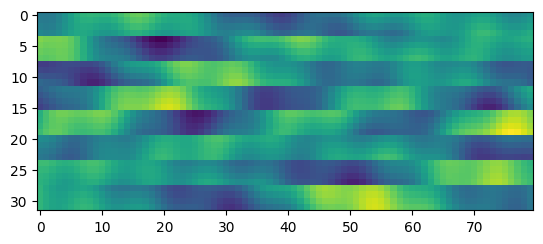

In [19]:
error = single_pred - single_zdl
plot(error)

np.complex64(0j)

In [ ]:
## Error Compression
error_compressor = ref.ReferenceKmeans(cfg, matlab)
model.train_or_load(error_compressor, cfg.kmeans_path, cfg.retrain_all, prediction_error)

# DL and UL each get trained pca, predictor, and error_compressor